In [1]:
# Module Import

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
# 설계할 때 활용하는 장ㅂ ㅣ확인 
if torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
    print('mps')
else:
    DEVICE = torch.device('cpu')
    print("cpu")
    
print('Using PyTorch version : ', torch.__version__, 'Deviece :', DEVICE )

mps
Using PyTorch version :  2.9.1 Deviece : mps


In [3]:
BATCH_SIZE = 32 # 한번 계산 할 때 사용할 데이터 수 
EPOCHS = 10 # 한번 전체를 도는 것이 epochs

In [4]:
# MNIST 데이터 다운로드 (Train Test Split)
train_dataset = datasets.FashionMNIST(root = "../data/FashionMNIST", 
                               train = True, 
                               download = True, 
                               transform = transforms.ToTensor())

test_dataset = datasets.FashionMNIST(root = "../data/FashionMNIST", 
                               train = False,  
                               transform = transforms.ToTensor()) # 이미지 파일을 tensor형태로 변경, 한 픽셀은 0 ~ 255 범위의 스칼라 값으로 구성, 이를 0 ~ 1 범위로 정규화

train_loader = torch.utils.data.DataLoader(dataset = train_dataset, 
                                           batch_size = BATCH_SIZE, #Batch_Size 만큼 데이터를 묶어 1개의 Mini-Batch 구성하기 위해 loader 구성
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset, 
                                           batch_size = BATCH_SIZE, 
                                           shuffle = False)

# loader을 구성하는 이유는 미니배치로 구성하기 위해 사용

100.0%
100.0%
100.0%
100.0%


In [5]:
# 데이터 확인하기 
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break


# X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor -> 32개의 이미지가 하나의 배치/ 그 이미지는 28 * 28 픽셀의 형태 
# y_train: torch.Size([32]) type: torch.LongTensor -> 이미지 하나당 하나의 레이블을 차지하므로, 한 배치의 레이블 수는 32개가 된다. 

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


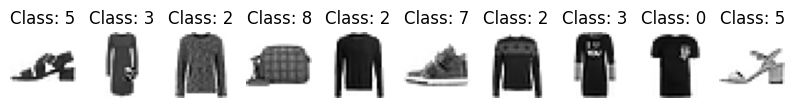

In [6]:
# 데이터 확인하기 2
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap = "gray_r")
    plt.title('Class: ' + str(y_train[i].item()))

In [9]:
# AE 모델 설계하기 (Forward propagation)

class AE(nn.Module):                      
    def __init__(self):                     
        super(AE, self).__init__()         # nn.Module 내에 있는 메서드를 상속 받아 이용할 수 있게끔

        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 512), 
            nn.ReLU(), 
            nn.Linear(512, 256), 
            nn.ReLU(), 
            nn.Linear(256, 32),)
        
        self.decoder = nn.Sequential(
            nn.Linear(32,256), 
            nn.ReLU(), 
            nn.Linear(256, 512), 
            nn.ReLU(), 
            nn.Linear(512, 28 * 28),)

    def forward(self, x) :                  # Forward propagation 정의
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [10]:
# optimizer, Objective Function 설정하기 (Back propagation)
model = AE().to(DEVICE)                    # DEVICE에 MLP 모델 할당
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Adam 모델 사용
criterion = nn.MSELoss()           # 벌점 이런거 주기 

print(model)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)


In [20]:
# AE 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 
def train(model, train_loader, optimizer, log_interval): 
    model.train()                           # MLP을 학습 상태로 지정
    for batch_idx, (image, __) in enumerate(train_loader):   # Mini-Batch 단위로 이미지 데이터가 묶여있음. => 순서대로 MLP 모형 학습
        image = image.view(-1, 28 * 28).to(DEVICE)            # 이미지 -> 장치에 할당
        target = image.view(-1, 28 * 28).to(DEVICE)            # 라벨 -> 장치에 할당
        optimizer.zero_grad()               # 지난번 할당한 것 지우는 것 
        
        encoded, decoded = model(image)               # 이미지 데이터를 인풋으로 모델을 돌려 아웃풋 계산
        loss = criterion(decoded, target)     # Loss funtion 작동
        loss.backward()                     # (auto_grad)계산된 gradient 값을 각 파라미터에 할당
        optimizer.step()                    # 업데이트

        if batch_idx % log_interval == 0:
            print("Train Epoch : {} [{} / {}({:.0f}%)]\tTrain Loss: {:6f}".format(Epoch, batch_idx * len(image), 
                                                                                  len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                                                                                  loss.item()))
            
            


In [21]:
# 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 
def evaluate(model, test_loader):
    model.eval()                            # 모델을 평가상태로 지정
    test_loss = 0                           # Loss 계산하기 위한 초기 설정
    real_image = []
    gen_image = []
    
    with torch.no_grad():                   # gradient를 통해 파라미터 값이 업데이트되는 현상을 방지
        for image, __ in test_loader:    # Mini-batch 내에 있는 이미지 데이터와 레이블 데이터에 접근
            image = image.view(-1, 28 * 28).to(DEVICE)        
            target = image.view(-1, 28 * 28).to(DEVICE)
            encoded, decoded = model(image)
            
            test_loss += criterion(decoded, image).item()    # 계산된 Output과 장비에 할당된 레이블 데이터를 기존에 정의한 CrossEntropy를 이용해 계산된 걸 test_loss
            real_image.append(image.to("cpu"))   # 계산된 벡터값 내 가장 큰 값인 위치에 해대 해당하는 위치에 대응하는 클래스로 예측 
            gen_image.append(decoded.to("cpu")) # correct에 맞춘 것 수 저장
            
    test_loss /= len(test_loader.dataset)   # test_loss를 mini-batch 개수만큼 나눠 평균 Loss값으로 계산
    return test_loss, real_image, gen_image

Train Epoch : 1 [0 / 60000(0%)]	Train Loss: 0.012515
Train Epoch : 1 [6400 / 60000(11%)]	Train Loss: 0.013854
Train Epoch : 1 [12800 / 60000(21%)]	Train Loss: 0.012620
Train Epoch : 1 [19200 / 60000(32%)]	Train Loss: 0.012347
Train Epoch : 1 [25600 / 60000(43%)]	Train Loss: 0.013323
Train Epoch : 1 [32000 / 60000(53%)]	Train Loss: 0.010525
Train Epoch : 1 [38400 / 60000(64%)]	Train Loss: 0.011289
Train Epoch : 1 [44800 / 60000(75%)]	Train Loss: 0.011109
Train Epoch : 1 [51200 / 60000(85%)]	Train Loss: 0.010986
Train Epoch : 1 [57600 / 60000(96%)]	Train Loss: 0.011839

[EPOCH: 1], 	Test Loss: 0.0004


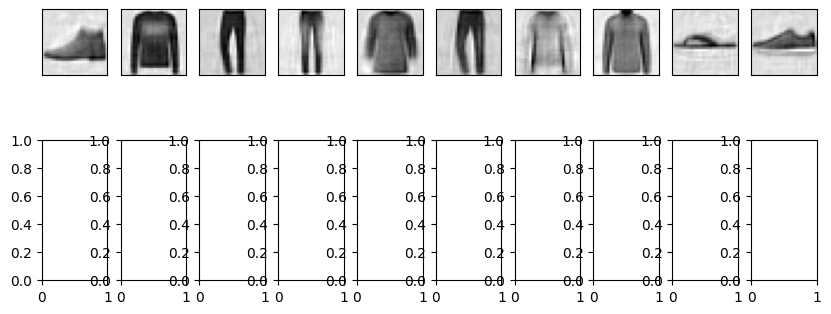

Train Epoch : 2 [0 / 60000(0%)]	Train Loss: 0.010912
Train Epoch : 2 [6400 / 60000(11%)]	Train Loss: 0.012331
Train Epoch : 2 [12800 / 60000(21%)]	Train Loss: 0.009492
Train Epoch : 2 [19200 / 60000(32%)]	Train Loss: 0.009440
Train Epoch : 2 [25600 / 60000(43%)]	Train Loss: 0.010765
Train Epoch : 2 [32000 / 60000(53%)]	Train Loss: 0.011072
Train Epoch : 2 [38400 / 60000(64%)]	Train Loss: 0.011587
Train Epoch : 2 [44800 / 60000(75%)]	Train Loss: 0.009197
Train Epoch : 2 [51200 / 60000(85%)]	Train Loss: 0.012870
Train Epoch : 2 [57600 / 60000(96%)]	Train Loss: 0.013459

[EPOCH: 2], 	Test Loss: 0.0004


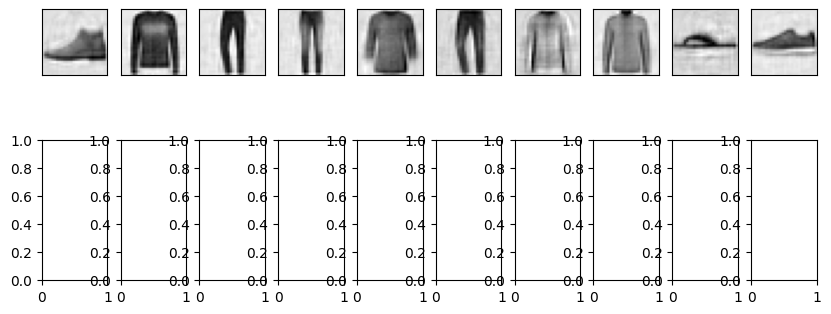

Train Epoch : 3 [0 / 60000(0%)]	Train Loss: 0.012034
Train Epoch : 3 [6400 / 60000(11%)]	Train Loss: 0.011024
Train Epoch : 3 [12800 / 60000(21%)]	Train Loss: 0.013548
Train Epoch : 3 [19200 / 60000(32%)]	Train Loss: 0.010609
Train Epoch : 3 [25600 / 60000(43%)]	Train Loss: 0.010175
Train Epoch : 3 [32000 / 60000(53%)]	Train Loss: 0.011991
Train Epoch : 3 [38400 / 60000(64%)]	Train Loss: 0.012102
Train Epoch : 3 [44800 / 60000(75%)]	Train Loss: 0.012606
Train Epoch : 3 [51200 / 60000(85%)]	Train Loss: 0.007817
Train Epoch : 3 [57600 / 60000(96%)]	Train Loss: 0.008928

[EPOCH: 3], 	Test Loss: 0.0003


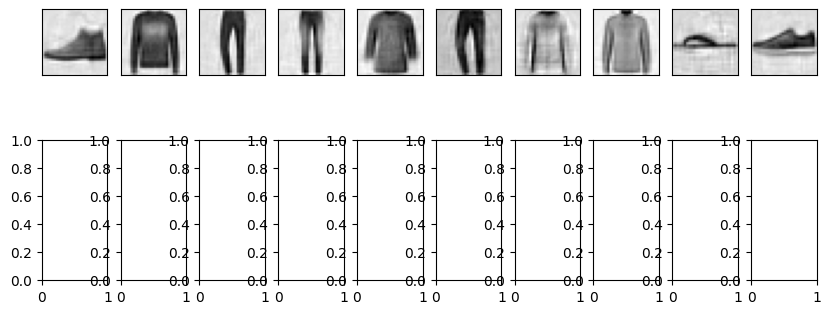

Train Epoch : 4 [0 / 60000(0%)]	Train Loss: 0.009312
Train Epoch : 4 [6400 / 60000(11%)]	Train Loss: 0.010118
Train Epoch : 4 [12800 / 60000(21%)]	Train Loss: 0.012619
Train Epoch : 4 [19200 / 60000(32%)]	Train Loss: 0.009688
Train Epoch : 4 [25600 / 60000(43%)]	Train Loss: 0.010866
Train Epoch : 4 [32000 / 60000(53%)]	Train Loss: 0.010338
Train Epoch : 4 [38400 / 60000(64%)]	Train Loss: 0.010435
Train Epoch : 4 [44800 / 60000(75%)]	Train Loss: 0.009925
Train Epoch : 4 [51200 / 60000(85%)]	Train Loss: 0.011610
Train Epoch : 4 [57600 / 60000(96%)]	Train Loss: 0.010387

[EPOCH: 4], 	Test Loss: 0.0003


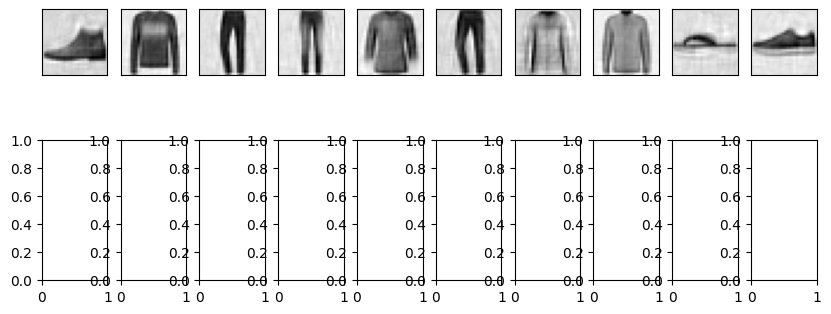

Train Epoch : 5 [0 / 60000(0%)]	Train Loss: 0.009392
Train Epoch : 5 [6400 / 60000(11%)]	Train Loss: 0.012317
Train Epoch : 5 [12800 / 60000(21%)]	Train Loss: 0.008241
Train Epoch : 5 [19200 / 60000(32%)]	Train Loss: 0.009590
Train Epoch : 5 [25600 / 60000(43%)]	Train Loss: 0.009106
Train Epoch : 5 [32000 / 60000(53%)]	Train Loss: 0.010036
Train Epoch : 5 [38400 / 60000(64%)]	Train Loss: 0.009898
Train Epoch : 5 [44800 / 60000(75%)]	Train Loss: 0.009982
Train Epoch : 5 [51200 / 60000(85%)]	Train Loss: 0.010347
Train Epoch : 5 [57600 / 60000(96%)]	Train Loss: 0.009910

[EPOCH: 5], 	Test Loss: 0.0003


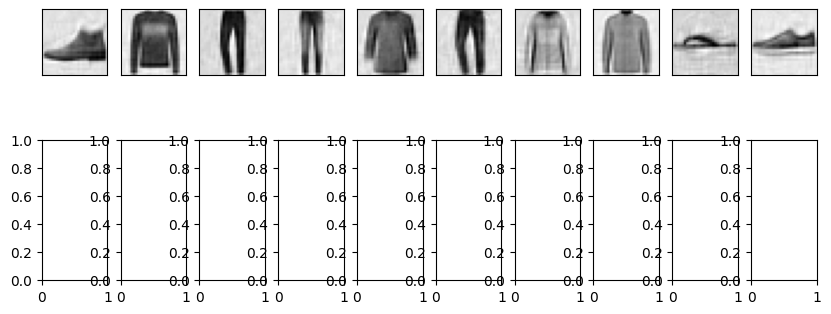

Train Epoch : 6 [0 / 60000(0%)]	Train Loss: 0.012203
Train Epoch : 6 [6400 / 60000(11%)]	Train Loss: 0.011688
Train Epoch : 6 [12800 / 60000(21%)]	Train Loss: 0.010465
Train Epoch : 6 [19200 / 60000(32%)]	Train Loss: 0.010305
Train Epoch : 6 [25600 / 60000(43%)]	Train Loss: 0.011720
Train Epoch : 6 [32000 / 60000(53%)]	Train Loss: 0.009782
Train Epoch : 6 [38400 / 60000(64%)]	Train Loss: 0.009989
Train Epoch : 6 [44800 / 60000(75%)]	Train Loss: 0.008387
Train Epoch : 6 [51200 / 60000(85%)]	Train Loss: 0.010375
Train Epoch : 6 [57600 / 60000(96%)]	Train Loss: 0.009557

[EPOCH: 6], 	Test Loss: 0.0003


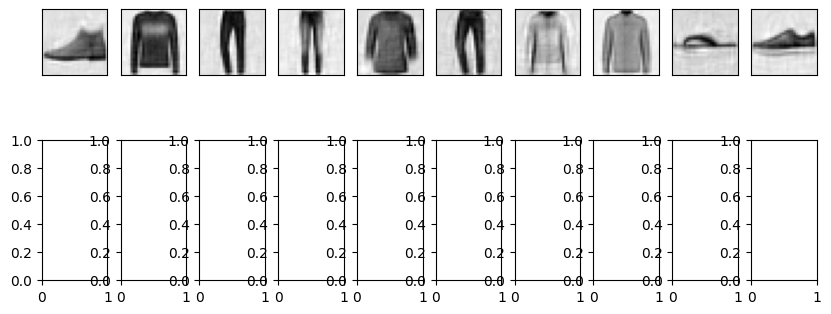

Train Epoch : 7 [0 / 60000(0%)]	Train Loss: 0.008732
Train Epoch : 7 [6400 / 60000(11%)]	Train Loss: 0.011027
Train Epoch : 7 [12800 / 60000(21%)]	Train Loss: 0.009721
Train Epoch : 7 [19200 / 60000(32%)]	Train Loss: 0.008196
Train Epoch : 7 [25600 / 60000(43%)]	Train Loss: 0.012468
Train Epoch : 7 [32000 / 60000(53%)]	Train Loss: 0.011153
Train Epoch : 7 [38400 / 60000(64%)]	Train Loss: 0.011112
Train Epoch : 7 [44800 / 60000(75%)]	Train Loss: 0.007746
Train Epoch : 7 [51200 / 60000(85%)]	Train Loss: 0.011560
Train Epoch : 7 [57600 / 60000(96%)]	Train Loss: 0.010769

[EPOCH: 7], 	Test Loss: 0.0003


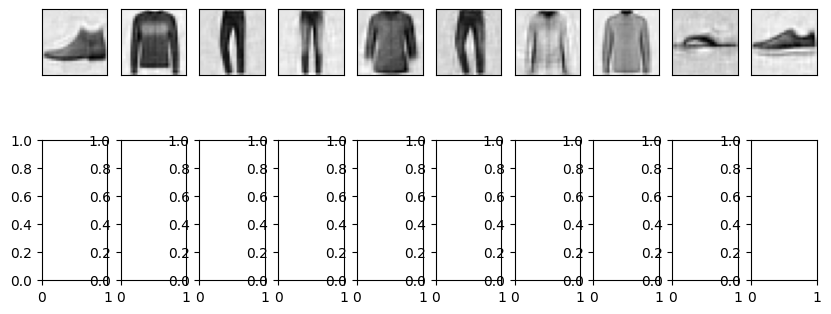

Train Epoch : 8 [0 / 60000(0%)]	Train Loss: 0.009142
Train Epoch : 8 [6400 / 60000(11%)]	Train Loss: 0.010336
Train Epoch : 8 [12800 / 60000(21%)]	Train Loss: 0.009538
Train Epoch : 8 [19200 / 60000(32%)]	Train Loss: 0.010610
Train Epoch : 8 [25600 / 60000(43%)]	Train Loss: 0.009748
Train Epoch : 8 [32000 / 60000(53%)]	Train Loss: 0.008517
Train Epoch : 8 [38400 / 60000(64%)]	Train Loss: 0.009632
Train Epoch : 8 [44800 / 60000(75%)]	Train Loss: 0.010813
Train Epoch : 8 [51200 / 60000(85%)]	Train Loss: 0.008995
Train Epoch : 8 [57600 / 60000(96%)]	Train Loss: 0.010399

[EPOCH: 8], 	Test Loss: 0.0003


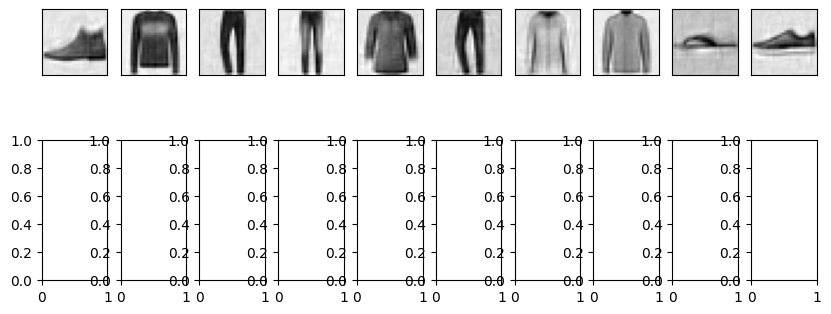

Train Epoch : 9 [0 / 60000(0%)]	Train Loss: 0.009601
Train Epoch : 9 [6400 / 60000(11%)]	Train Loss: 0.012336
Train Epoch : 9 [12800 / 60000(21%)]	Train Loss: 0.009448
Train Epoch : 9 [19200 / 60000(32%)]	Train Loss: 0.009360
Train Epoch : 9 [25600 / 60000(43%)]	Train Loss: 0.008328
Train Epoch : 9 [32000 / 60000(53%)]	Train Loss: 0.010859
Train Epoch : 9 [38400 / 60000(64%)]	Train Loss: 0.009506
Train Epoch : 9 [44800 / 60000(75%)]	Train Loss: 0.008976
Train Epoch : 9 [51200 / 60000(85%)]	Train Loss: 0.010231
Train Epoch : 9 [57600 / 60000(96%)]	Train Loss: 0.008620

[EPOCH: 9], 	Test Loss: 0.0003


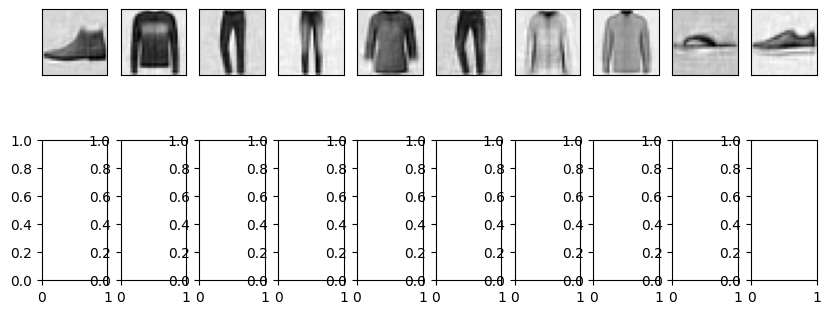

Train Epoch : 10 [0 / 60000(0%)]	Train Loss: 0.012180
Train Epoch : 10 [6400 / 60000(11%)]	Train Loss: 0.009014
Train Epoch : 10 [12800 / 60000(21%)]	Train Loss: 0.011233
Train Epoch : 10 [19200 / 60000(32%)]	Train Loss: 0.009266
Train Epoch : 10 [25600 / 60000(43%)]	Train Loss: 0.012465
Train Epoch : 10 [32000 / 60000(53%)]	Train Loss: 0.011118
Train Epoch : 10 [38400 / 60000(64%)]	Train Loss: 0.009190
Train Epoch : 10 [44800 / 60000(75%)]	Train Loss: 0.009427
Train Epoch : 10 [51200 / 60000(85%)]	Train Loss: 0.011926
Train Epoch : 10 [57600 / 60000(96%)]	Train Loss: 0.010947

[EPOCH: 10], 	Test Loss: 0.0003


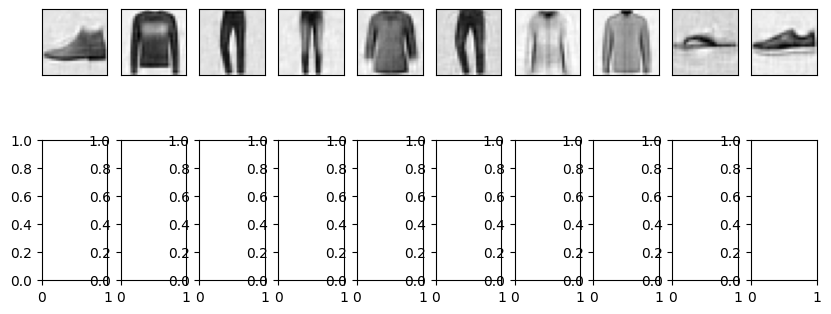

In [24]:
# MLP 학습을 실행하면서 Train, Test  set의 Loss 및 Test set Accuracy를 확인하기
for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, real_image, gen_image  = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}".format(Epoch, test_loss))
    f, a = plt.subplots(2, 10, figsize = (10, 4))
    for i in range(10):
        img = np.reshape(real_image[0][i],(28, 28))
        a[0][i].imshow(img, cmap = "gray_r")
        a[0][i].set_xticks(())
        a[0][i].set_yticks(())

    for i in range(10):
        img = np.reshape(gen_image[0][i],(28, 28))
        a[0][i].imshow(img, cmap = "gray_r")
        a[0][i].set_xticks(())
        a[0][i].set_yticks(())
    plt.show()
# 여기서 log_interval은 뭘까?

# 
    